### General approach

Our goal is to construct a low-rank approximation of a data matrix $A$ of DNA methylation patterns (with many missing data points). Each row of $A$ contains a binary sequence of methylation, $A_{ij} = 1$ for methylated sites, $A_{ij} = 0$ for unmethylated sites, and $A_{ij} = \text{NA}$ when site $j$ is unobserved in read $i$. We factor $A$ as a product of two matrices $X$ and $Y$:

$$
A = XY \\ A \in \mathbf{R}^{m \times n},~~ X \in \mathbf{R}^{m \times k},~~ Y \in \mathbf{R}^{k \times n}
$$

That is, we have a dataset $m$ reads that provide partial information over $n$ methylation-eligible sites of interest (e.g. over a selected number of genes, or, more ambitiously, over the entire genome). We suppose that there are no more than $k$ types of cells with distinct methylation patterns.

The rows of $Y$ provide the estimates for the $k$ distinct methylation patterns. A row of $X$ assigns the relative probabilities for that read to one of the $k$ patterns. An interesting question is whether we believe the rows of $X$ to be sparse. A sparse rowspace of $X$ would correspond to there being distinct methylation patterns across cell types, with little to no mixed patterns. A non-sparse rowspace would allow for a spectrum of different DNA methylation profiles.

### Niave Optimization Approach

We use $x_i$ to denote row $i$ of $X$, and $y_j$ to denote column $j$ of $Y$, so that $x_i y_j$ is a vector dot product. Let $(i,j) \in \Omega$ denote the indices of observed entries in $A$. Then a low-rank approximation can be achieved by solving the unconstrained optimization problem:

$$
\begin{aligned}
& \underset{X,Y}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} \log(1+\exp(-A_{ij} (x_i y_j)) - \gamma ||X||_F^2 - \gamma||Y||_F^2 
\end{aligned}
$$

The first term is a logistic loss function. The last two are regularization terms that penalize the *Frobenius norm* of the matrices. [Udell et al. (2014)](http://web.stanford.edu/~udell/doc/glrm.pdf) show that this problem is very closely related to the rank-constrained nuclear-norm regularized problem (see Thm. 1):

$$
\begin{aligned}
& \underset{X,Y}{\text{minimize}}
& & \sum_{(i,j) \in \Omega} \log(1+\exp(-A_{ij} (x_i y_j)) - 2 \gamma ||XY||_*^2 \\
& \text{subject to}
& & \text{rank}(Z) \leq k
\end{aligned}
$$

as long as $k$ is chosen to be larger than the true rank of $A$. The *Frobenius norm* and *nuclear norm* are respectively defined as:

$$
||X||_F = \sqrt{\sum_{i=1}^k \sigma_i^2} = \sqrt{ \text{trace} \left ( X^T X \right ) } \\
||X||_* = \sum_{i=1}^k \sigma_i = \text{trace} \left ( \sqrt{X^T X} \right )
$$

### Ideas for improvement

Clustering variation: have the rows of $X$ be one-sparse

Combination/spectrum of cell types variation: have the rows of $X$ sum to one and have non-negative elements

### Relevant Papers on Matrix Completion

Emmanuel J. Candès, Benjamin Recht. [Exact Matrix Completion via Convex Optimization](http://dx.doi.org/10.1007/s10208-009-9045-5). *Found Comput Math* 9, 717–772 (2009)

Emmanuel J. Candès, Terence Tao. [The Power of Convex Relaxation: Near-Optimal Matrix Completion](http://dx.doi.org/10.1109/tit.2010.2044061). *IEEE Transactions on Information Theory* 56, 2053–2080 (2010).

Emmanuel J Candès, Yaniv Plan. [Matrix Completion With Noise](http://dx.doi.org/10.1109/jproc.2009.2035722). *Proc. IEEE* 98, 925–936 (2010).

Benjamin Recht, Maryam Fazel, Pablo A. Parrilo. [Guaranteed Minimum-Rank Solutions of Linear Matrix Equations via Nuclear Norm Minimization](http://dx.doi.org/10.1137/070697835). *SIAM Rev.* 52, 471–501 (2010).

Nicolas Gillis, François Glineur. [Low-Rank Matrix Approximation with Weights or Missing Data is NP-hard](http://arxiv.org/pdf/1012.0197.pdf). *SIAM. J. Matrix Anal. & Appl.* 32(4), 1149–1165. (2011)

N. Srebro, T. Jaakkola. [Weighted Low-Rank Approximations](https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf), *ICML Conference Proceedings* (2004)

### Notes

* In classic PCA, there is only one global minimum (corresponding to the SVD solution), and many saddle points (corresponding to critical points with lower-magnitude eigen
* Weighted low-rank matrix completion can have problem might have several local minima which are not global... What about saddle points??


In [1]:
using LowRankModels
using Distributions
include("methylation_functions.jl");

INFO: Loading help data...


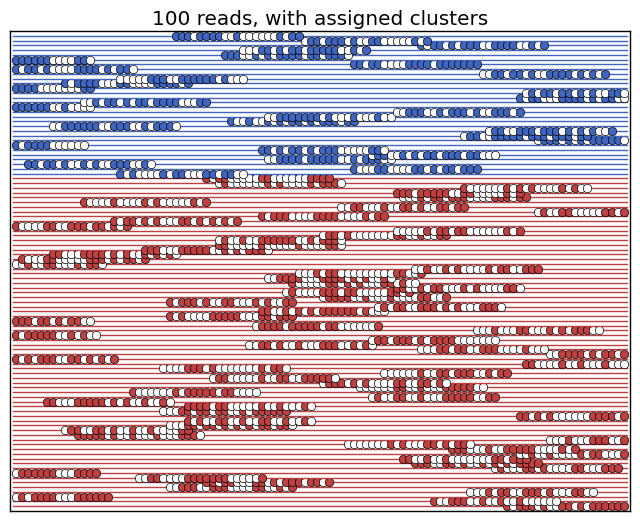

PyObject <matplotlib.text.Text object at 0x7f79d373b350>

In [20]:
A,P,c = generate_reads(N=100,W=20)
plot_meth(A,c)
title("100 reads, with assigned clusters")

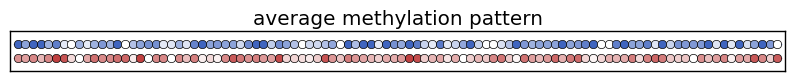

PyObject <matplotlib.text.Text object at 0x7f79d1319ad0>

In [21]:
figure(figsize=(10,size(P,1)*0.25))
plot_meth_avg(A,c)

In [22]:
# find indices of observed find(~isnan(X[:,1])
m,n = size(A)
k = 2 # we know there are two cell types

obs = (Int64,Int64)[]
for i = 1:m
    for j = 1:n
        if ~isnan(A[i,j])
            push!(obs,(i,j))
        end
    end
end

In [23]:
function run_fit(loss,rx,ry,initX,initY)
    losses = fill(loss,n)
    glrm = GLRM(A,obs,losses,rx,ry,k)
    
    if initX != nothing
        glrm.X = initX
    end
    if initY != nothing
        glrm.Y = initY
    end
    
    X,Y,ch = fit!(glrm,verbose=false)
    println("Final Objective: ",ch.objective[end])
    return X,Y,ch
end

function run_batch(loss_function,rx,ry,initX,initY,N)
    best = Inf
    X,Y,ch = 0,0,0
    for i = 1:N
        Xest,Yest,ch_ = run_fit(loss_function,rx,ry,initX,initY)
        if ch_.objective[end] < best
            best = ch_.objective[end]
            X,Y,ch = Xest,Yest,ch_
        end
    end
    println("Best Objective: ",ch.objective[end])
    return X,Y,ch
end

function evaluate_loss(loss_function,rx,ry;N=20,initX=nothing,initY=nothing)
    X,Y,ch = run_batch(loss_function,rx,ry,initX,initY,N);
    
    plot_cluster_assignments(X);
    return X,Y,ch
end

function plot_cluster_assignments(X)
    # reconstruct "true" x (up to a permutation of rows)
    x_real = zeros(size(X))
    for i = 1:m
        x_real[i,c[i]] = 1
    end
    
    # plot cluster assignments for first and last N reads
    N = 100
    matshow(X')
    xlabel("Inferred Cluster Assignments")
    matshow(x_real')
    xlabel("True Cluster Assignments")
end

plot_cluster_assignments (generic function with 1 method)

Final Objective: 1448.9793621852398
Final Objective: 1498.9441218734537
Final Objective: 1461.7134186692808
Final Objective: 1454.9077094540344
Final Objective: 1510.4660589108464
Final Objective: 1503.068957583908
Final Objective: 1470.9646161970568
Final Objective: 1492.771365447303
Final Objective: 1469.7512698988844
Final Objective: 1505.2673187241023
Final Objective: 1492.8859596449952
Final Objective: 1491.161143014848
Final Objective: 1467.129739762454
Final Objective: 1498.0634469715803
Final Objective: 1477.5930930490847
Final Objective: 1507.8136738046996
Final Objective: 1482.9982997822394
Final Objective: 1512.5297276269885
Final Objective: 1491.1521841045662
Final Objective: 1495.3362775243002
Best Objective: 1448.9793621852398


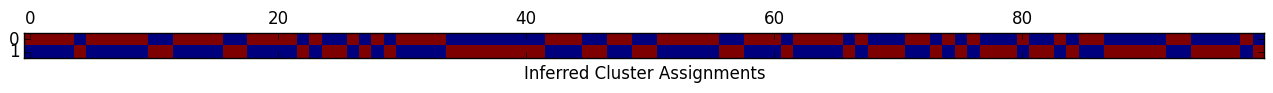

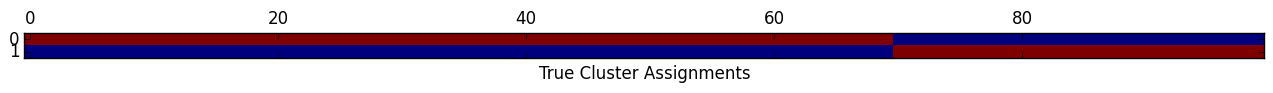

In [24]:
evaluate_loss(quadratic(),unitonesparse(),zeroreg());

Final Objective: 1451.8877751460684
Final Objective: 1470.058709514574
Final Objective: 1445.9578256477123
Final Objective: 1499.1164729320726
Final Objective: 1474.2888384595626
Final Objective: 1507.3320396152842
Final Objective: 1496.0767823878134
Final Objective: 1451.3403573275045
Final Objective: 1516.4245950651937
Final Objective: 1507.3759680283117
Final Objective: 1471.1296255018158
Final Objective: 1452.2488879863006
Final Objective: 1464.3756722470487
Final Objective: 1449.9172064400038
Final Objective: 1454.0284790835765
Final Objective: 1459.6826861942047
Final Objective: 1463.4151601388414
Final Objective: 1468.0247577386776
Final Objective: 1476.487317804711
Final Objective: 1478.8654616490294
Best Objective: 1445.9578256477123


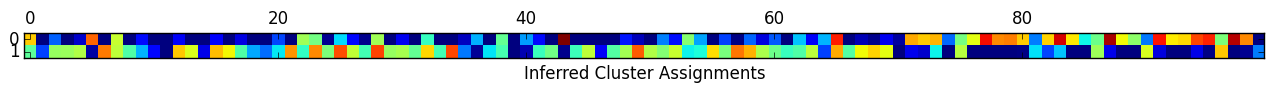

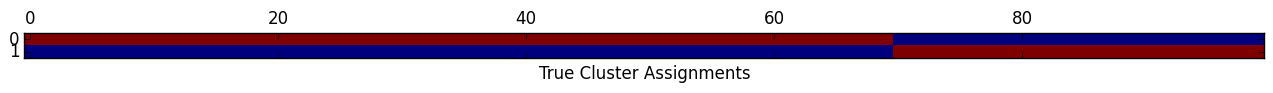

In [30]:
X,Y,ch = evaluate_loss(quadratic(),nonneg_onereg(5),zeroreg());

Final Objective: 1833.8465876734476
Final Objective: 1912.7155742852074
Final Objective: 1883.1235607760361
Final Objective: 1985.1520291067516
Final Objective: 1848.5328993683231
Final Objective: 1869.619277421788
Final Objective: 1953.5861067442195
Final Objective: 2072.368366264995
Final Objective: 1868.7450365422685
Final Objective: 1960.0071867608553
Final Objective: 1937.6217116226849
Final Objective: 1944.0066146221927
Final Objective: 2035.6463648995827
Final Objective: 1946.0251565702529
Final Objective: 1738.338303507265
Final Objective: 1930.094256532732
Final Objective: 1936.7186327610873
Final Objective: 1908.7247319319101
Final Objective: 1801.5322763774996
Final Objective: 2041.6423258110779
Best Objective: 1738.338303507265


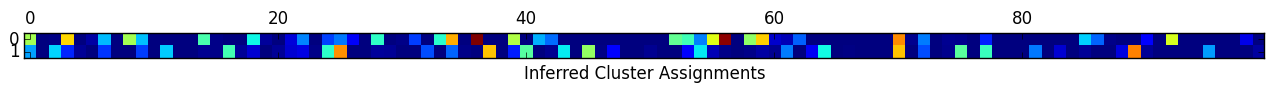

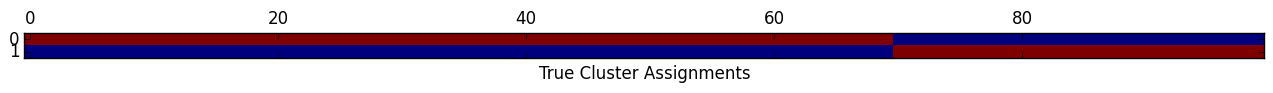

In [31]:
evaluate_loss(logistic(),nonneg_onereg(5),zeroreg());

Final Objective: 1364.0629784630812
Final Objective: 1364.0546143197644
Final Objective: 1364.0545067410624
Final Objective: 1364.0545049872148
Final Objective: 1364.0545049555797
Final Objective: 1364.0545049549812
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Final Objective: 1364.0545049549692
Best Objective: 1364.0545049549692


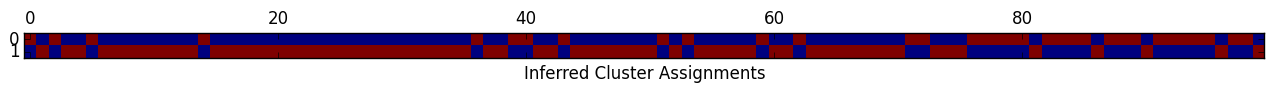

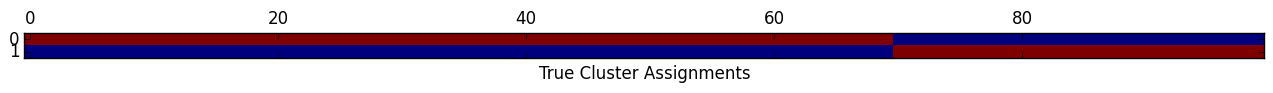

In [32]:
X_,Y_,ch_ = evaluate_loss(quadratic(),unitonesparse(),zeroreg(),initX=X,initY=Y);

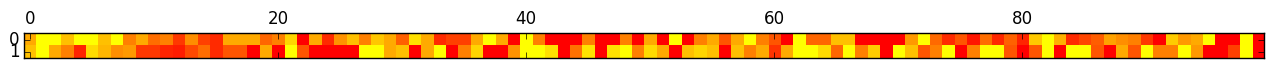

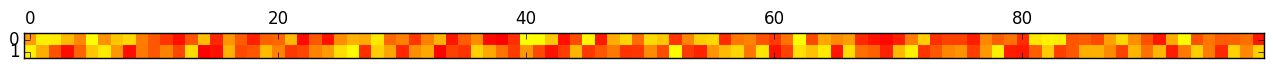

PyObject <matplotlib.image.AxesImage object at 0x7f79d37d74d0>

In [19]:
matshow(Y_,cmap=ColorMap("autumn"))
matshow(P,cmap=ColorMap("autumn"))